Script para la el analisis de componentes principales

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
#import statsmodels.api as sm
import xarray as xr

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Mapas
# ==============================================================================
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [36]:
# Rutas
rutaera = 'D:/Documentos/Maestria/DATOS ERA5/ERA5/DATASET_ERA5.nc'
ruta = 'D:/Documentos/Maestria/MLG/'
save = 'D:/Documentos/Maestria/MLG/IMGS/'
mpl.rcParams["axes.formatter.limits"]=[-2, 3]

### PCA Data array

In [ ]:
# Lectura de los datos
data = xr.open_dataset(rutaera)

In [5]:
# Descarte de la temperatura minima
X = data.drop('mn2t')

In [6]:
# - Funcion para convertir datasets en arrays
def to_array(dt):
    var = list(dt.keys())
    arr = np.zeros((len(dt.time), len(var)))*np.nan
    
    for i in range(len(var)):
        arr[:,i] = dt[var[i]].values
        
    return arr

In [17]:
# Arrays para guardar los resultados de los PCA segun las variables que se tengan y el numero de PCAs
n_pca = 4
n_var = 5
pca_arr = np.zeros((n_pca,len(X.latitude),len(X.longitude)))*np.nan
comp = np.zeros((n_pca,n_var,len(X.latitude),len(X.longitude)))*np.nan
X_arr = np.zeros((len(X.time),n_var,len(X.latitude),len(X.longitude)))*np.nan

In [22]:
# - Loop para calcular PCAs
for i in range(X.latitude.shape[0]):
    for j in range(X.longitude.shape[0]):
        # - Procesamiento solo en zonas de interes
        if (np.isnan(X.d2m[:,i,j]).sum())<10:
            # - Seleccion de solo un pixel para pca indicviduales 
            lat = X.latitude[i]
            lon = X.longitude[j]
            x_sub = X.sel(latitude = lat, longitude = lon)
            # - Conversion en array de shape (n_samples, n_features)
            x_arr = to_array(x_sub)
            # - Escalamiento
            scaler=StandardScaler()
            ld=scaler.fit(x_arr)
            X_scaled=ld.transform(x_arr)
            
            # - PCA a cada pixel
            pca = PCA(n_components=n_pca, svd_solver='full').fit(X_scaled)
            # - Guardado arrays
            pca_arr[:,i,j] = pca.explained_variance_ratio_
            X_arr[:,:, i, j] = X_scaled
            comp[:,:,i,j] = pca.components_

In [29]:
# Guardado de la varianza explicada por los PCA
varratio = xr.DataArray(pca_arr, 
                        coords = {'PCA':[1,2,3,4], 
                                  'lat':X.latitude.values,
                                  'lon':X.longitude.values}, 
                        dims = ['PCA','lat','lon'])

In [37]:
varratio.to_netcdf(ruta+'varratio.nc')

In [34]:
# Guardado del aporte de las variables a los PCA
components = xr.DataArray(comp, 
                          coords = {'PCA':[1,2,3,4],
                                    'var_weight':list(X.keys()),
                                    'lat':X.latitude.values,
                                    'lon':X.longitude.values}, 
                          dims = ['PCA', 'var_weight', 'lat', 'lon'])

In [38]:
components.to_netcdf(ruta+'components.nc')

In [15]:
index = [[0,1,2],
         [3,4]]

In [21]:
bar = [0.91, 0.2, 0.02, 0.6]

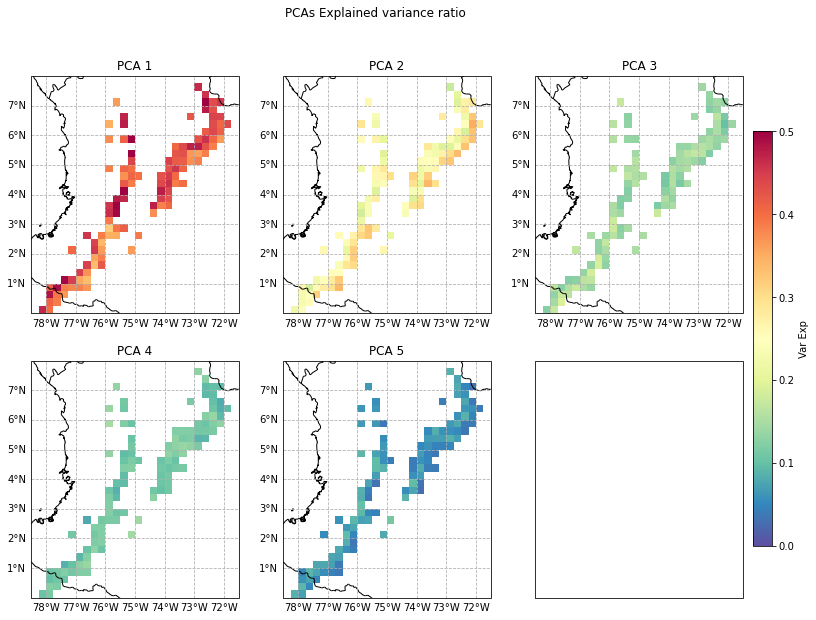

In [37]:
# Gráficas de la variaza explicada por los PCA
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(12.8, 9.6)
                      ,sharex=True, sharey=True,
                      subplot_kw={'projection': ccrs.PlateCarree()})

for r in range(len(index)):
    for c in range(len(index[r])):
        lons = X.longitude
        lats = X.latitude
        
        ax[r,c].coastlines()
        ax[r,c].add_feature(cfeature.BORDERS)
        gl = ax[r,c].gridlines(draw_labels=True,linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

        im = ax[r,c].pcolormesh(lons,lats,pca_arr[index[r][c]],
                                cmap='Spectral_r',vmin=0.0,vmax=0.5)
        ax[r,c].set_title('PCA '+str(index[r][c]+1))
        ax[r,c].set_extent([-78.5, -71.5, 0, 8], crs=ccrs.PlateCarree())
        
cax = fig.add_axes(bar)
cbar = fig.colorbar(im,cax=cax)
cbar.set_label('Var Exp')
fig.suptitle('PCAs Explained variance ratio')
#plt.savefig(save+'PCAs_varratio.png', dpi=300)

In [66]:
prom_pca = np.nanmean(pca_arr,axis=(1,2))
prom_com = np.nanmean(comp,axis=(2,3))

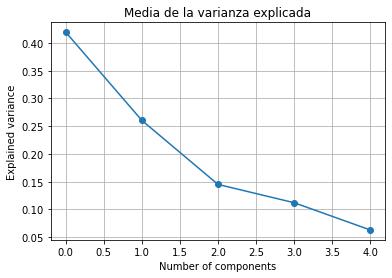

In [46]:
plt.plot(prom_pca, '-o')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid()
plt.title('Media de la varianza explicada')
#plt.savefig(save+'pca_vrmean.png', dpi=300)

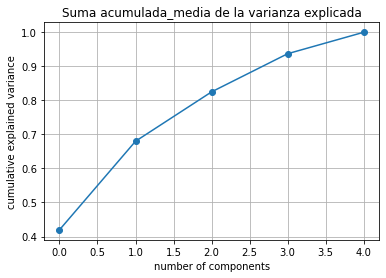

In [47]:
plt.plot(np.cumsum(prom_pca), '-o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.title('Suma acumulada_media de la varianza explicada')
#plt.savefig(save+'pca_vrsum.png', dpi=300)

In [70]:
list(X.keys())

['d2m', 'lcc', 'str', 'tp', 'u10']

In [71]:
# - Grafica de los pesos de las variables en los PCA
def pca_results(X, components, varratio):
    
    dimensions = ['Dim. {}'.format(i) for i in range(1,len(components)+1)]
    
    components = pd.DataFrame(np.round(components, 4), columns = list(X.keys())) 
    components.index = dimensions

    ratios = varratio.reshape(len(components), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (14,8))

    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    for i, ev in enumerate(varratio): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Expl. Var.\n %.4f"%(ev))

    return pd.concat([variance_ratios, components], axis = 1)

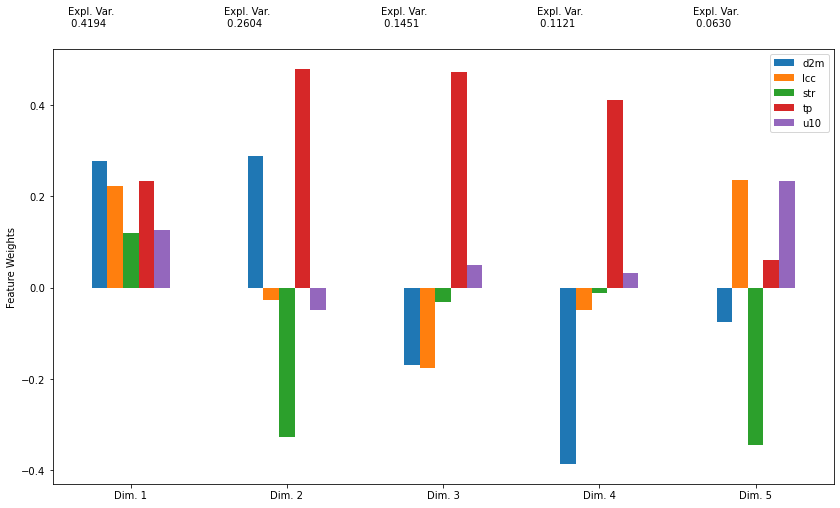

In [73]:
pca_results(X, prom_com, prom_pca)
#plt.savefig(save+'pca_resuls.png', dpi = 300)

### PCA dataframe

In [6]:
df = pd.read_csv(ruta)

In [12]:
df = df.drop('Unnamed: 0',axis=1)

In [13]:
# Remocion de outliers
factor = 1.3
cols = list(df.columns)
for i in range(len(cols)):
    upper_lim = df[cols[i]].mean () + df[cols[i]].std () * factor
    lower_lim = df[cols[i]].mean () - df[cols[i]].std () * factor
    
    df = df[(df[cols[i]] < upper_lim) & (df[cols[i]] > lower_lim)]

In [14]:
scaler=StandardScaler()
ld=scaler.fit(df)
df2=ld.transform(df)

In [18]:
y = df2[:,0]
x = df2[:,1:]

In [26]:
df.columns

Index(['mn2t', 'd2m', 'lcc', 'str', 'tp', 'u10', 'v10'], dtype='object')

In [ ]:
pca = PCA(n_components=6)

In [42]:
pca.fit(x)

PCA(n_components=5)

In [93]:
pca.explained_variance_ratio_

array([0.23763699, 0.18963543, 0.16832583, 0.14777705, 0.13293017])

In [44]:
pca.explained_variance_ratio_.sum()

0.8763054662272338

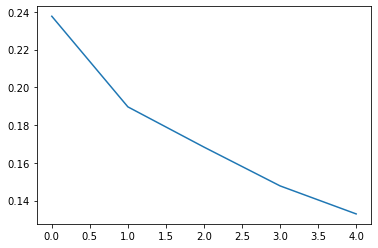

In [45]:
plt.plot(pca.explained_variance_ratio_)

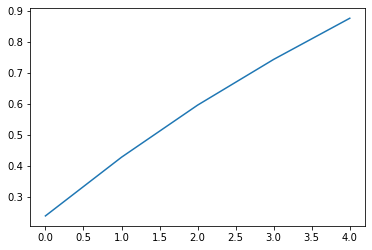

In [46]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))